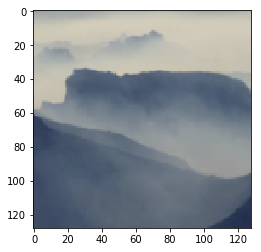

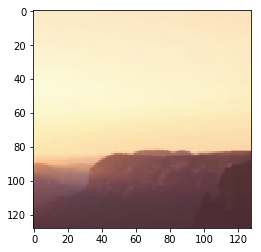

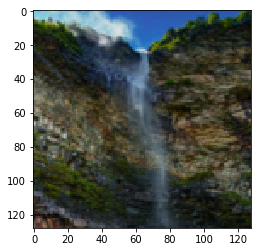

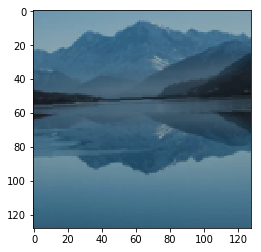

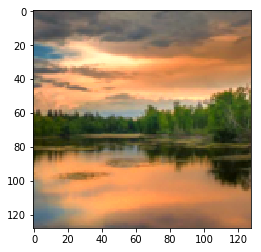

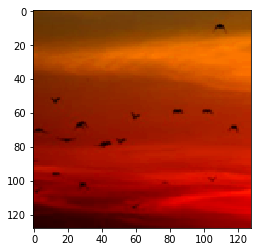

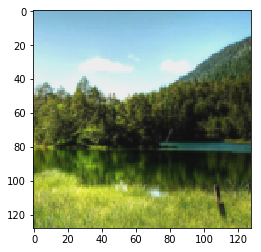

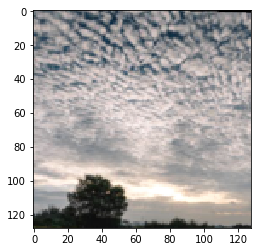

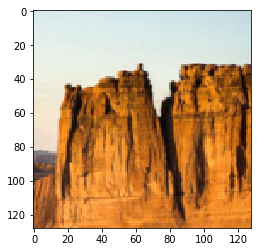

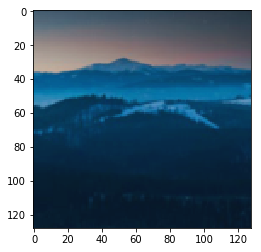

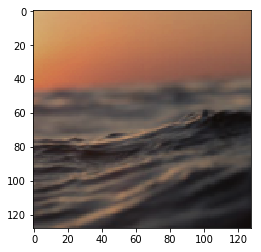

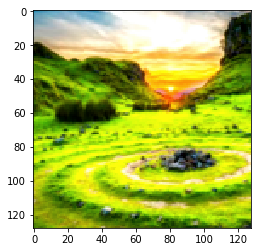

In [1]:
%matplotlib inline

import torch as th
import torchvision
import matplotlib.pyplot as plt
import Dataloader
import os

# select the device to be used for training
device = th.device("cuda" if th.cuda.is_available() else "cpu")

transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(3),
    torchvision.transforms.RandomCrop((256, 256)), # TODO: Random scale too
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(.2, .2, .1, .01),
    torchvision.transforms.ToTensor(),
  ])

dataset_dir = os.environ['DATASET_DIR']
dataset = Dataloader.FlatDirectoryImageDataset(dataset_dir + '/pexels/landscapes', transform=transforms)

for i, d in enumerate(dataset):
    plt.imshow(d.permute(1, 2, 0).numpy())
    plt.show()
    if i > 10:
         break



In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

vgg = models.vgg13_bn(pretrained=True).to(device)

# freeze all model parameters
vgg.eval()
for param in vgg.parameters():
    param.requires_grad = False


def extract_features(x):
  # x = normalize(x)  # TODO
  #print(x.min(), x.max())
  
  # This is an approximation of the transform that the torchvision models want.
  x = (x - .5) * .3

  for i in range(12):
    x = vgg.features[i](x)
  return x

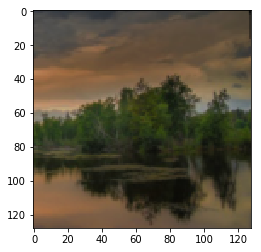

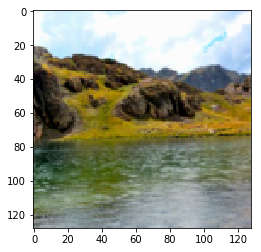

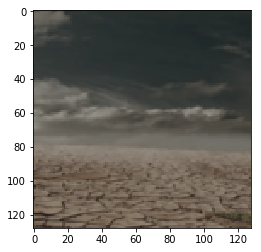

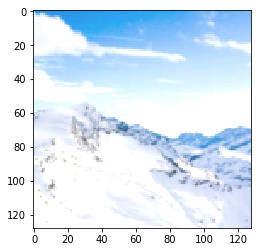

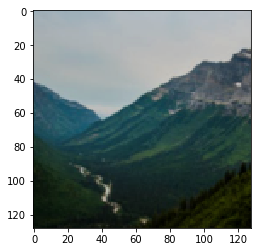

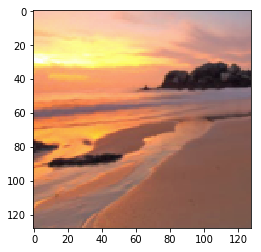

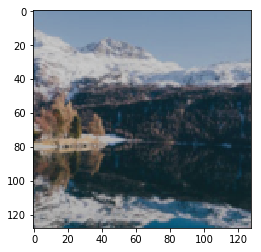

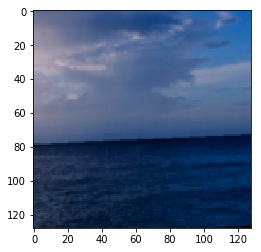

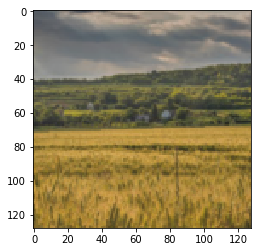

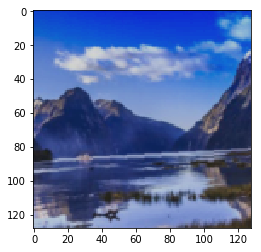

In [3]:
num_pins = 64

dataloader = torch.utils.data.DataLoader(dataset, num_pins, shuffle=True)
anchor_targets = next(iter(dataloader)).to(device)
for i in range(10):
    plt.imshow(anchor_targets[i].permute(1, 2, 0).cpu().numpy())
    plt.show()

batch_size = 32
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)



In [4]:
def create_grid(samples, img_file, scale_factor=1):
    """
    utility function to create a grid of GAN samples
    :param samples: generated samples for storing
    :param scale_factor: factor for upscaling the image
    :param img_file: name of file to write
    :return: None (saves a file)
    """
    from torchvision.utils import save_image
    from torch.nn.functional import interpolate

    # upsample the image
    if scale_factor > 1:
        samples = interpolate(samples, scale_factor=scale_factor)

    # save the images:
    save_image(samples, img_file, nrow=int(np.sqrt(len(samples))), normalize=True)

In [5]:
import PRO_GAN
import torch

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2

latent_size = 128

g = PRO_GAN.Generator(depth=7, latent_size=latent_size).to(device)

anchor_latent_vectors = torch.randn(num_pins, latent_size, requires_grad=True, device=device)

#anchor_optimizer = torch.optim.Adam(list(g.parameters()) + [anchor_latent_vectors], lr=.001)
anchor_optimizer = torch.optim.Adam(list(g.parameters()), lr=.001)

anchor_targets = anchor_targets.to(device)

def optimize_generator_with_anchors():
    generated = g(anchor_latent_vectors, 5, 0)
    assert anchor_targets.shape == generated.shape, "generated shape %s does not match target shape %s" % (str(generated.shape), str(target.shape))
    loss = torch.mean(torch.abs(anchor_targets - generated))
    perceptual_loss = torch.mean(torch.abs(extract_features(anchor_targets) - extract_features(generated)))
    
    anchor_optimizer.zero_grad()
    loss.backward()
    anchor_optimizer.step()
    
    return loss.item()


In [6]:
"""for i in tqdm(range(100)):
    loss, generated = optimize_generator_with_anchors()
    
    filename = 'samples/%d.png' % i
    create_grid(generated, filename)
    if i % 100 == 0:
        print(loss)
        plt.imshow(cv2.imread(filename))
        plt.show()"""

"for i in tqdm(range(100)):\n    loss, generated = optimize_generator_with_anchors()\n    \n    filename = 'samples/%d.png' % i\n    create_grid(generated, filename)\n    if i % 100 == 0:\n        print(loss)\n        plt.imshow(cv2.imread(filename))\n        plt.show()"

In [ ]:
import Losses

d = PRO_GAN.Discriminator(7, latent_size).to(device)

disc_optim = torch.optim.Adam(d.parameters())
wgan_gp = Losses.WGAN_GP(d, use_gp=True)

def optimize_discriminator():
    real_samples = next(iter(dataloader)).to(device)
    
    noise = torch.randn(batch_size, latent_size, device=device)
    fake_samples = g(noise, 5, 0).detach()

    loss = wgan_gp.dis_loss(real_samples, fake_samples, 5, 0)

    disc_optim.zero_grad()
    loss.backward()
    disc_optim.step()
    
    return loss.item()

for i in range(5):
    print(optimize_discriminator())
    

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


8.704471588134766
8.058988571166992
7.366033554077148
6.262557029724121
5.10178279876709


  0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


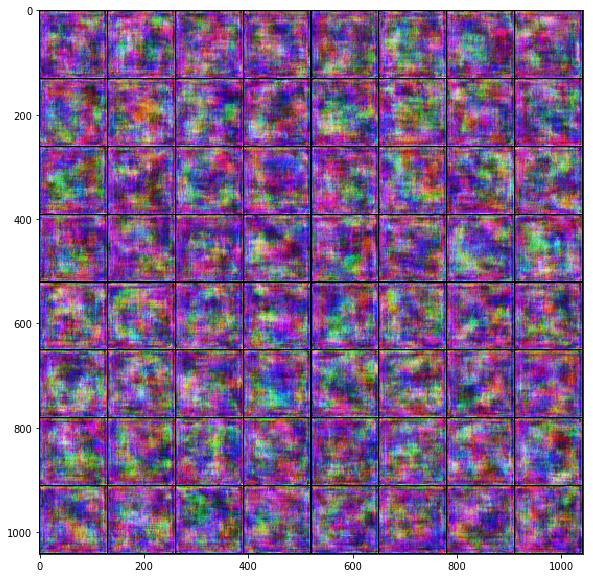

  0%|          | 58/50000 [00:45<10:50:15,  1.28it/s]

In [ ]:
gen_optim = torch.optim.Adam(g.parameters())


def optimize_generator():
    real_samples = next(iter(dataloader)).to(device)
    
    noise = torch.randn(batch_size, latent_size, device=device)
    fake_samples = g(noise, 5, 0).detach()

    loss = wgan_gp.gen_loss(real_samples, fake_samples, 0, 5)

    gen_optim.zero_grad()
    loss.backward()
    gen_optim.step()
    
    return loss.item()

eval_noise = torch.randn(64, latent_size, device=device)

for i in tqdm(range(50 * 1000)):
    
    # For the first phase, just train using the anchors. This is faster.
    if i > 500:
        disc_loss = optimize_discriminator()
        gen_loss = optimize_generator()
    
    gen_loss_2 = optimize_generator_with_anchors()
    
    generated = g(eval_noise, 5, 0).detach()
    
    filename = 'samples/%d.png' % i
    create_grid(generated, filename)
    if i % 100 == 0:
        plt.rcParams['figure.figsize'] = [10, 10]
        plt.imshow(cv2.imread(filename))
        plt.show()
    
    

In [ ]:
def interpolate_latent_vectors(vector_a, vector_b):
    vectors = torch.zeros(64, latent_size, device=device)
    for i in range(64):
        vectors[i] = vector_b * (i / 64.0) + vector_a * (1 - i / 64.0)
    generated = g(vectors, 5, 0)
    
    filename = 'samples/interpolation.png'
    create_grid(generated, filename)
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(cv2.imread(filename))
    plt.show()
        

interpolate_latent_vectors(anchor_latent_vectors[0], anchor_latent_vectors[8])